# Initialization

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style('white')
from math import ceil
import joblib
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
file_path = # Input your file path here

In [4]:
data = pd.read_csv(file_path + 'data_all_europe.csv')

In [9]:
data[['Year', 'Country', 'Target']]['Country'].unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
       'Luxembourg', 'Netherlands', 'North Macedonia', 'Norway', 'Poland',
       'Portugal', 'Republic of Moldova', 'Romania', 'Russian Federation',
       'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom'], dtype=object)

In [ ]:
# Add Yield to the data
data['Yield'] = data['Target'] / data['Cropland (1000 ha)']
data = data.drop('Cropland (1000 ha)', axis = 1)

# Move it to the front
Yield = data.pop('Yield')
data.insert(3, Yield.name, Yield)

# Rename data columns
data.columns = ['Year', 'Country', 'Production', 'Yield', 'Pesticides', 'Fertilizer (N)', 'Fertilizer (K2O)',
       'Fertilizer (P2O5)', 'Fertilizer (Total)',
       'Agricultural Value Added', 'Mean Temperature', 'Precipitation',
       'Agricultural Employment', 'FPI', 'Population',
       'Agricultural Machinery', 'Export Value',
       'Export Avg Price', 'Import Value',
       'Import Avg Price', 'Urbanization']

data = data.drop('Production', axis =1)


In [ ]:
# Fill the most recent point (2021) with the mean value
for c in data['Country'].unique():
    for col in data.columns[2:]:
        last_idx = data[data['Country'] == c][col].index[-1]
        last_value = data.at[last_idx, col]

        if pd.isna(last_value):
            mean = data[data['Country'] == c][col].mean()
            data.at[last_idx, col] = mean


for col in data.columns[2:]:
    for c in data['Country'].unique():

        df = data.loc[data['Country'] == c, col]
        mean = df.mean()

        idx1 = df.isna().idxmax()
        idx2 = df.isna().idxmin()

        # Backward filling
        if idx1 < idx2:
          data.loc[data['Country'] == c, col] = df.fillna(df.loc[idx2])

        # Forward filling
        elif idx1 > idx2:
          data.loc[data['Country'] == c, col]= df.fillna(mean)


In [ ]:
data.isna().sum()

Year                         0
Country                      0
Yield                        0
Pesticides                  16
Fertilizer (N)               0
Fertilizer (K2O)             0
Fertilizer (P2O5)            0
Fertilizer (Total)           0
Agricultural Value Added     0
Mean Temperature             0
Precipitation                0
Agricultural Employment      0
FPI                          0
Population                   0
Agricultural Machinery       0
Export Value                 0
Export Avg Price             0
Import Value                 0
Import Avg Price             0
Urbanization                 0
dtype: int64

<Axes: >

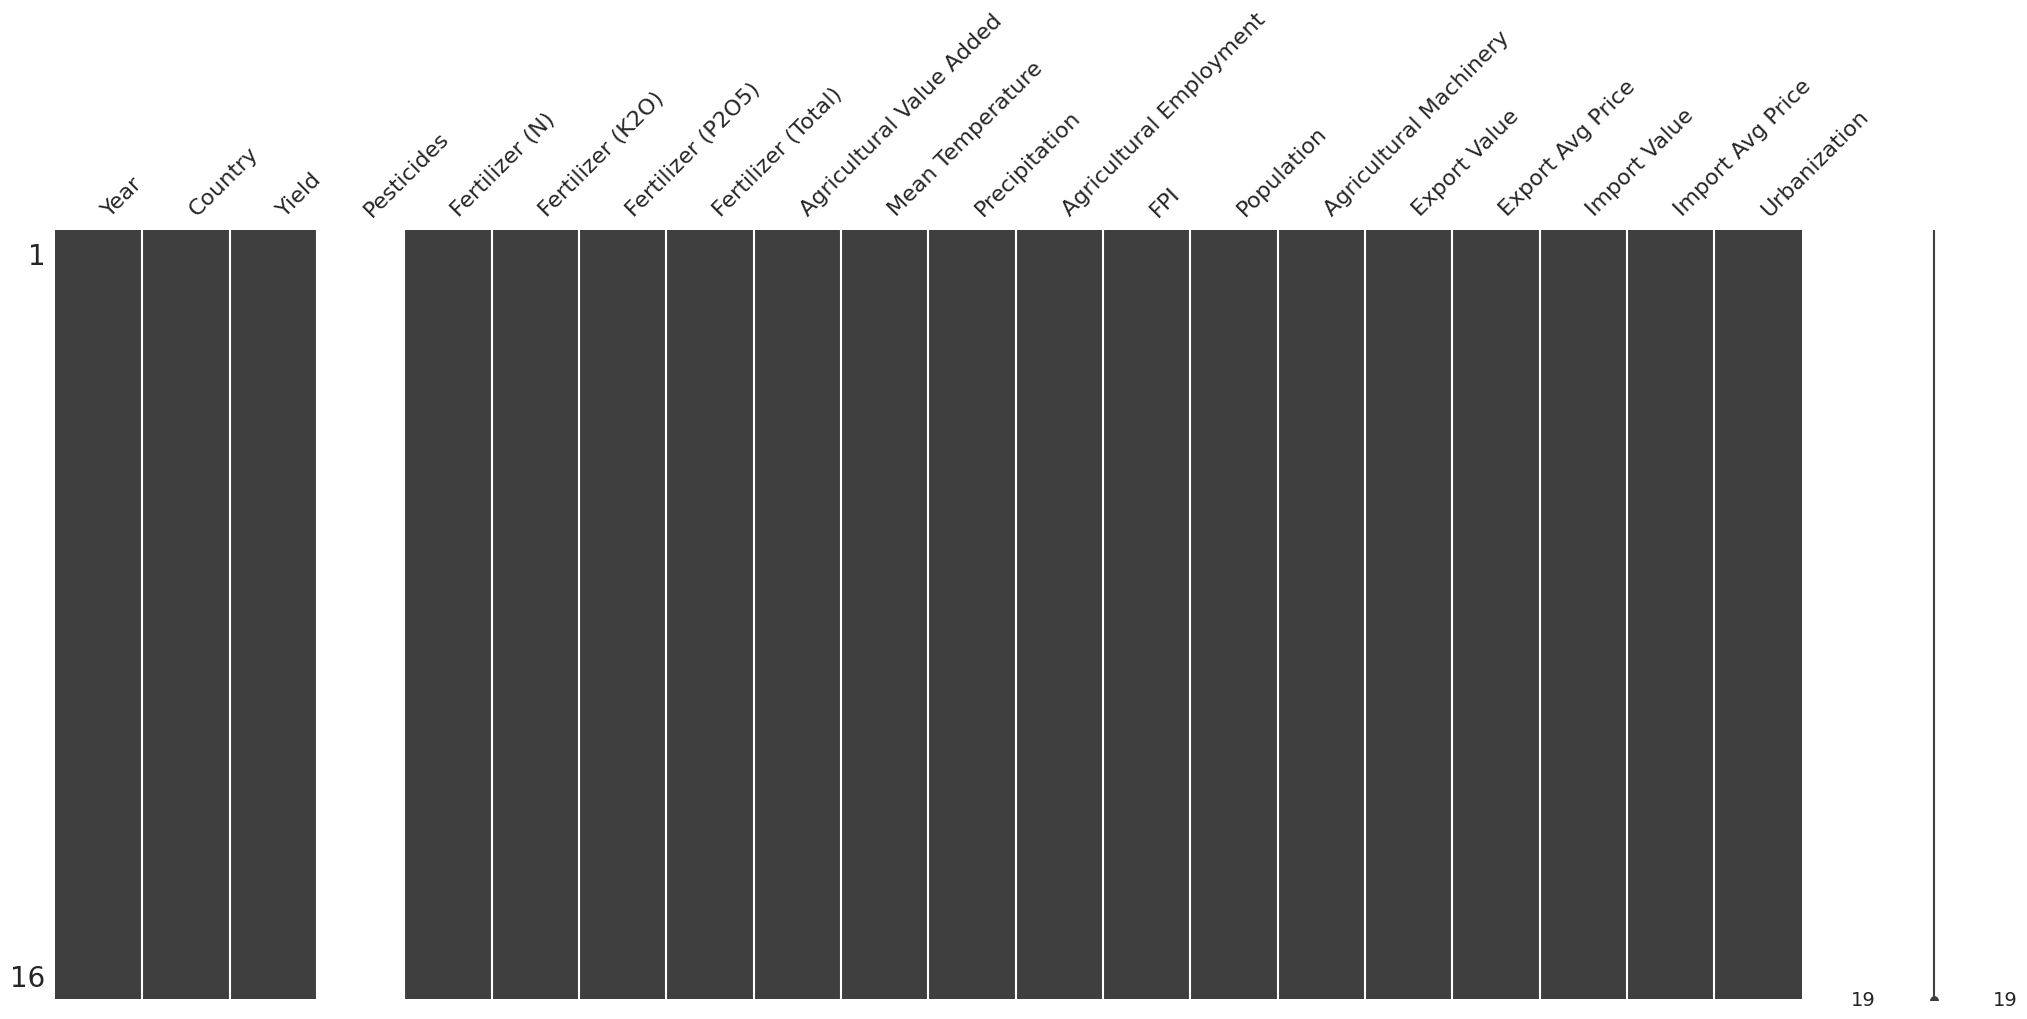

In [ ]:
import missingno as mn
mn.matrix(data[data['Country'] == 'Serbia'])

In [ ]:
data_long = data[['Country', 'Year', 'Yield']].pivot(index='Year', columns='Country', values='Yield')

data_long.corr()['Serbia'].sort_values(ascending = False).head(5)

# data[data['Country'] == 'Serbia']['Pesticides'] = data[data['Country'] == 'Serbia']['Pesticides']

Country
Serbia                 1.000000
Romania                0.834745
Estonia                0.729964
Greece                 0.673746
Republic of Moldova    0.611569
Name: Serbia, dtype: float64

In [ ]:
# Separate data for Serbia and Romania
data_serbia_pesticides = data[data['Country'] == 'Serbia'][['Year', 'Pesticides']]
data_romania_pesticides = data[data['Country'] == 'Romania'][['Year', 'Pesticides']]

# Rename columns in the second DataFrame
data_romania_pesticides = data_romania_pesticides.rename(columns={'Year': 'Year_Romania', 'Pesticides': 'Pesticides_Romania'})

# Join data using .join()
data_serbia_pesticides = data_serbia_pesticides.join(data_romania_pesticides.set_index('Year_Romania'), on='Year', how='left')

data.loc[data['Country'] == 'Serbia', 'Pesticides'] = data_serbia_pesticides['Pesticides_Romania']


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1729 non-null   int64  
 1   Country                   1729 non-null   object 
 2   Yield                     1729 non-null   float64
 3   Pesticides                1729 non-null   float64
 4   Fertilizer (N)            1729 non-null   float64
 5   Fertilizer (K2O)          1729 non-null   float64
 6   Fertilizer (P2O5)         1729 non-null   float64
 7   Fertilizer (Total)        1729 non-null   float64
 8   Agricultural Value Added  1729 non-null   float64
 9   Mean Temperature          1729 non-null   float64
 10  Precipitation             1729 non-null   float64
 11  Agricultural Employment   1729 non-null   float64
 12  FPI                       1729 non-null   float64
 13  Population                1729 non-null   float64
 14  Agricult

In [ ]:
data.columns

Index(['Year', 'Country', 'Yield', 'Pesticides', 'Fertilizer (N)',
       'Fertilizer (K2O)', 'Fertilizer (P2O5)', 'Fertilizer (Total)',
       'Agricultural Value Added', 'Mean Temperature', 'Precipitation',
       'Agricultural Employment', 'FPI', 'Population',
       'Agricultural Machinery', 'Export Value', 'Export Avg Price',
       'Import Value', 'Import Avg Price', 'Urbanization'],
      dtype='object')

# Modelling

In [ ]:
data_copy = data.drop(['Year', 'Country'], axis = 1)

## Log transform to deal with positive skew

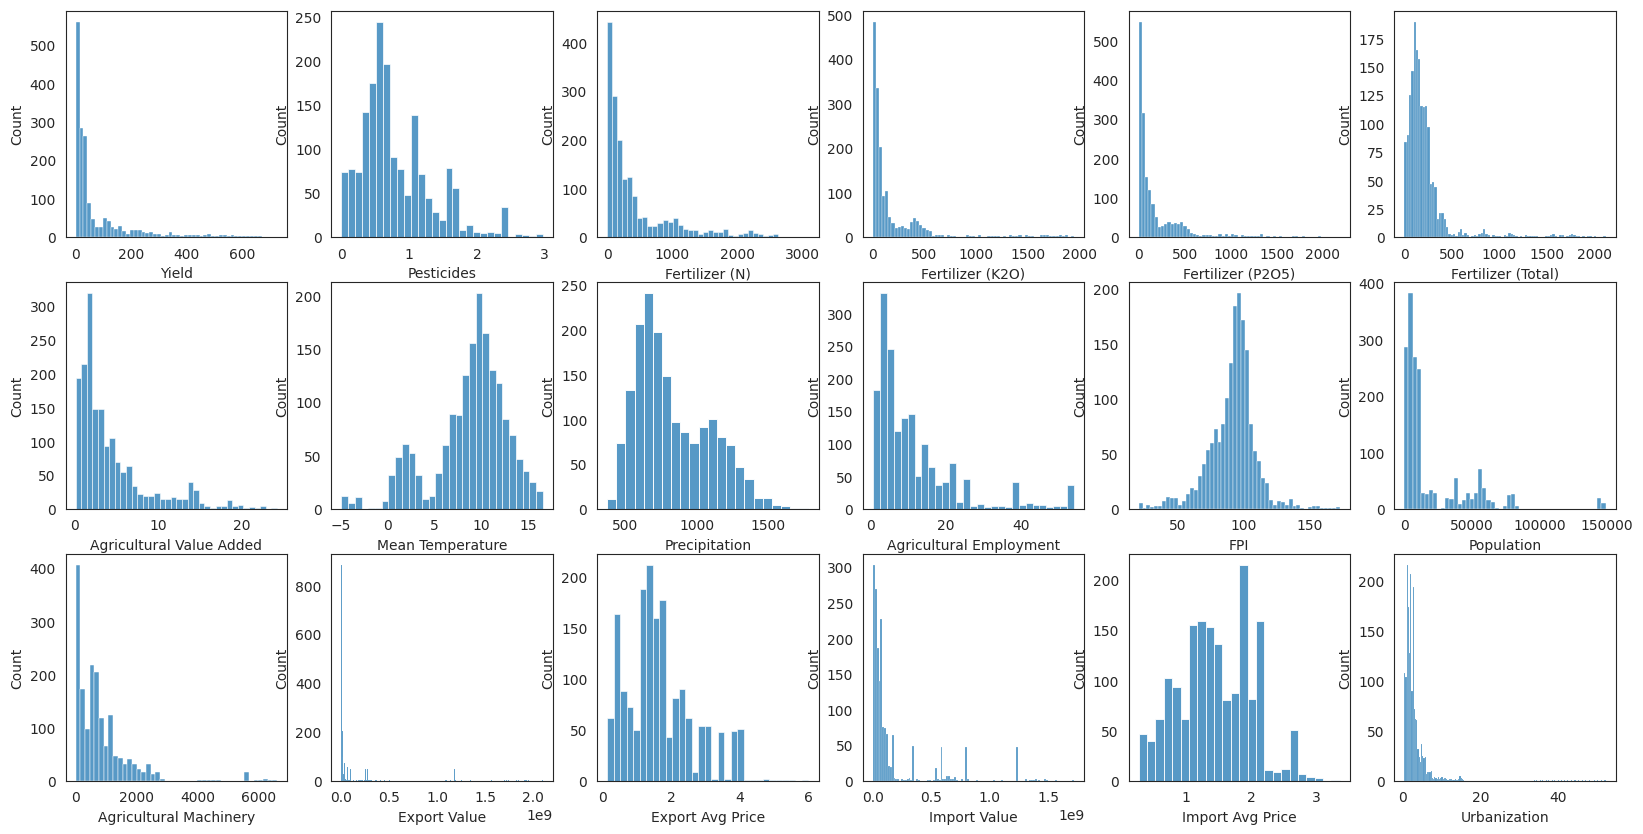

In [ ]:
cols = data_copy.columns

fig, ax = plt.subplots(nrows = ceil(len(cols)/6), ncols = 6, figsize = (20, 10))
ax = ax.flatten()

for idx, col in enumerate(cols):
  sns.histplot(x = data_copy[col], ax = ax[idx])
  # ax[idx].set_title(col)

In [ ]:
cols_to_transform = data_copy.drop(['Mean Temperature', 'Precipitation', 'FPI', 'Export Avg Price', 'Import Avg Price'], axis=1).columns

df_transformed = data_copy.copy()

# Apply log1p transformation to selected columns
df_transformed[cols_to_transform] = np.log(df_transformed[cols_to_transform])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
# Checking for missing values (NaN)
missing_values = df_transformed.isna().sum()
print("Missing values in each column:")
print(missing_values)

# Checking for infinity (inf)
infinity_values = np.isinf(df_transformed.iloc[:, 2:]).sum()
print("\nInfinity values in the DataFrame:")
print(infinity_values)

Missing values in each column:
Yield                       0
Pesticides                  0
Fertilizer (N)              0
Fertilizer (K2O)            0
Fertilizer (P2O5)           0
Fertilizer (Total)          0
Agricultural Value Added    0
Mean Temperature            0
Precipitation               0
Agricultural Employment     0
FPI                         0
Population                  0
Agricultural Machinery      0
Export Value                0
Export Avg Price            0
Import Value                0
Import Avg Price            0
Urbanization                0
dtype: int64

Infinity values in the DataFrame:
Fertilizer (N)              11
Fertilizer (K2O)            29
Fertilizer (P2O5)           16
Fertilizer (Total)           0
Agricultural Value Added     0
Mean Temperature             0
Precipitation                0
Agricultural Employment      0
FPI                          0
Population                   0
Agricultural Machinery       0
Export Value                 0
Export Av

In [ ]:
# Replace inf values with NaN
df_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_train_transformed = df_transformed.dropna()

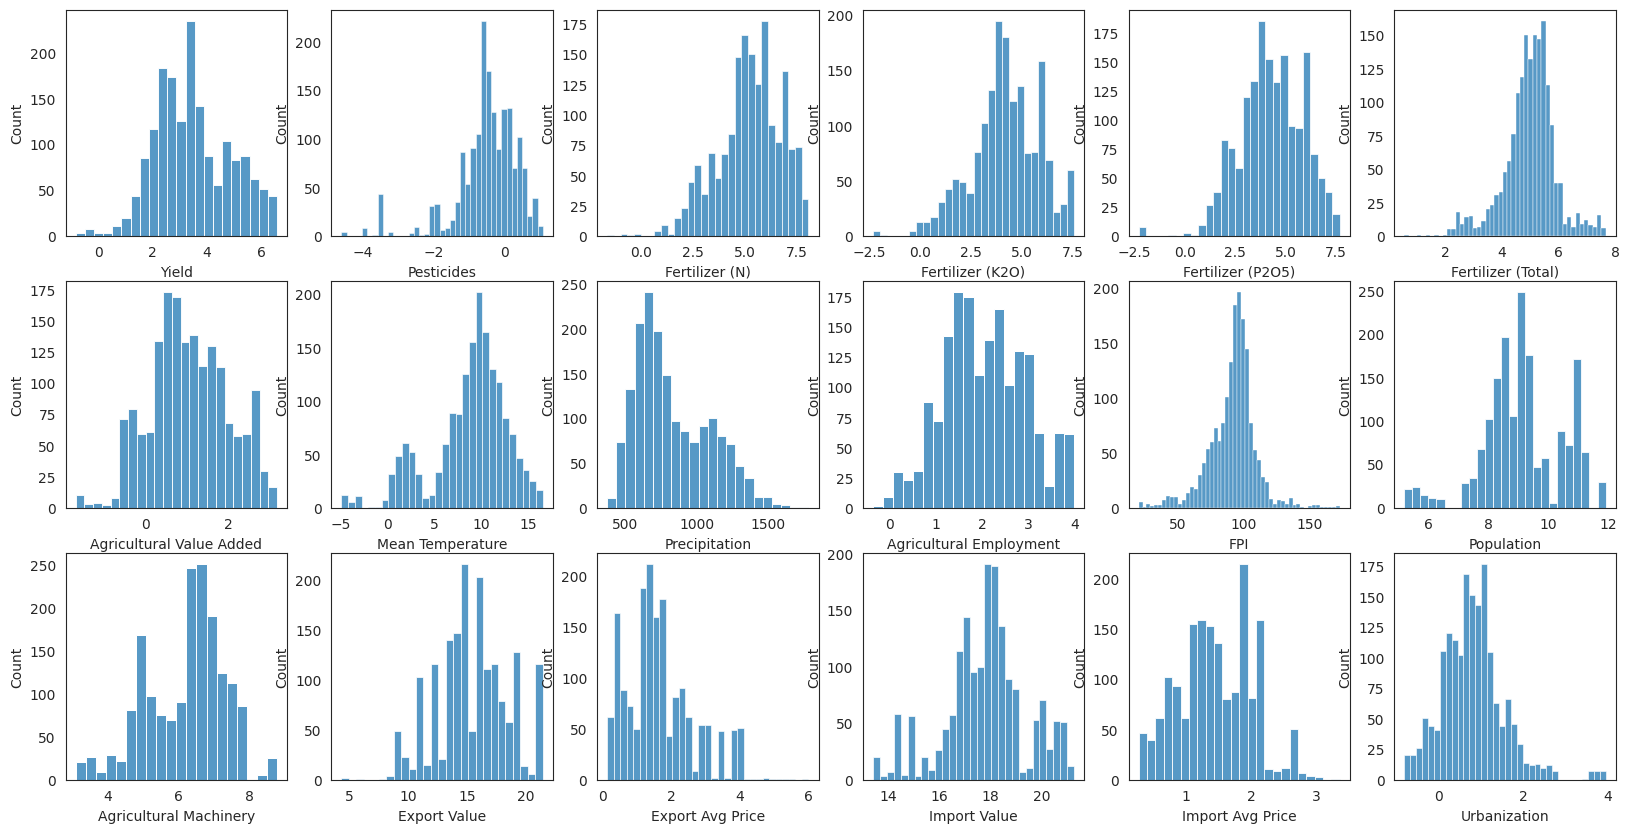

In [ ]:
cols = df_transformed.columns

fig, ax = plt.subplots(nrows = ceil(len(cols)/6), ncols = 6, figsize = (20, 10))
ax = ax.flatten()

for idx, col in enumerate(cols):
  sns.histplot(x = df_transformed[col], ax = ax[idx])
  # ax[idx].set_title(col)

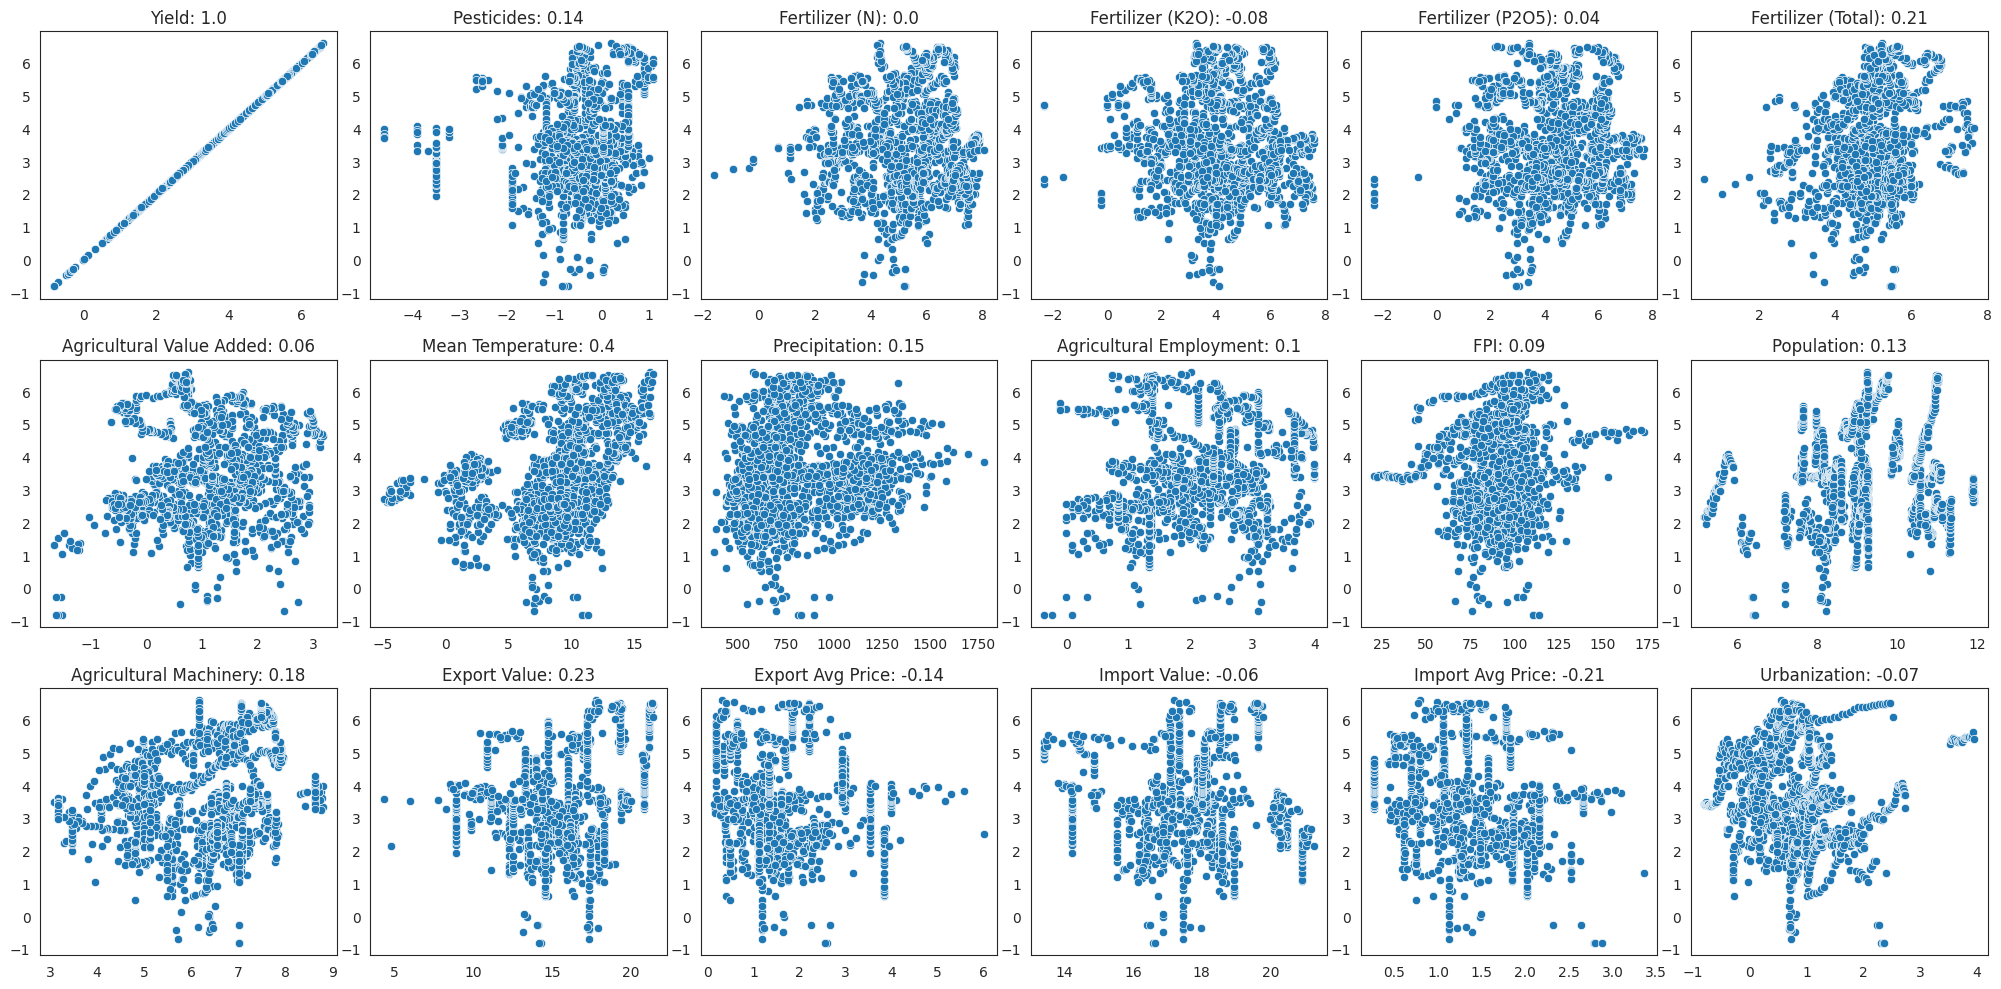

In [ ]:
cols = df_transformed.columns

fig, ax = plt.subplots(nrows = ceil(len(cols)/6), ncols = 6, figsize = (20, 10))
ax = ax.flatten()

for idx, col in enumerate(cols):
  corr = round(df_transformed['Yield'].corr(df_transformed[col]), 2)
  sns.scatterplot(x = df_transformed[col], y = df_transformed['Yield'],ax = ax[idx])
  ax[idx].set_xlabel('')
  ax[idx].set_ylabel('')
  ax[idx].set_title(f'{col}: {corr}')

plt.tight_layout()

plt.savefig(file_path + '/plot/transformed_scatter.png')

## Preprocess

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data_copy, test_size = 0.2, random_state=42)

# Feature selected
# df_train, df_test = train_test_split(data_copy.drop(['Export Avg Price', 'Agricultural Employment', 'Fertilizer (P2O5)', 'Fertilizer (K2O)', 'Precipitation'], axis = 1), test_size = 0.2, random_state=42)

In [ ]:
# Split train and test by X and y
X_train = df_train.drop('Yield',axis = 1 )
y_train = df_train['Yield']
X_test  = df_test.drop('Yield', axis = 1)
y_test  = df_test['Yield']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1383, 17)
(1383,)
(346, 17)
(346,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = columns)

# ensures that the testing data is scaled using the same mean and s.d.
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = columns)


In [ ]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

## Linear Models(with/without Regularization)

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

# Fit the linear regression model
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

In [ ]:
joblib.dump(results, file_path + 'linear_regression_model.pkl')

['drive/MyDrive/Modelling/linear_regression_model.pkl']

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     117.8
Date:                Sat, 19 Aug 2023   Prob (F-statistic):          1.83e-263
Time:                        11:53:39   Log-Likelihood:                -9149.9
No. Observations:                1556   AIC:                         1.834e+04
Df Residuals:                    1538   BIC:                         1.843e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In this OLS (Ordinary Least Squares) regression analysis:

* **R-squared (R²)**: The R-squared value is 0.566, which indicates that approximately 56.6% of the variation in the dependent variable 'Yield' is explained by the independent variables included in the model.

* **F-statistic (F-value)**: The F-statistic is 117.8, and the associated p-value is very close to zero (1.83e-263). This indicates that the model as a whole is highly statistically significant, suggesting that at least one of the independent variables has a significant effect on 'Yield.'

* **P-values (P>|t|):** The p-values associated with each independent variable (features) test the null hypothesis that the corresponding coefficient is equal to zero. In this analysis, several features have low p-values, indicating that they are statistically significant predictors of 'Yield.'

The results suggest that the OLS regression model is statistically significant and explains a substantial portion (56.6%) of the variability in 'Yield.' Many of the included independent variables are statistically meaningful in predicting 'Yield,' as indicated by their low p-values. However, it's worth noting that some features, such as 'Fertilizer (K2O),' 'Fertilizer (P2O5),' 'Precipitation,' 'Agricultural Employment,' and 'Export Avg Price,' have p-values greater than 0.05, suggesting that they may not be statistically significant predictors of 'Yield' in this model.

#### Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(best_alpha)


# Use the best alpha to fit the Ridge model
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

1


Ridge(alpha=1)

In [ ]:
joblib.dump(ridge_model, file_path + 'ridge_model.pkl')

['drive/MyDrive/Modelling/ridge_model.pkl']

#### Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

# Use the best alpha to fit the Lasso model
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

0.1


Lasso(alpha=0.1)

In [ ]:
joblib.dump(lasso_model, file_path + 'lasso_model.pkl')

['drive/MyDrive/Modelling/lasso_model.pkl']

In [ ]:
# Get the coefficients from the trained Lasso model
coefficients = lasso_model.coef_

# Get the corresponding feature names
feature_names = X_train.columns

# Identify the features with zero coefficients
zero_coefficient_features = feature_names[coefficients == 0]

print("Features with Coefficient Zero:", zero_coefficient_features)

Features with Coefficient Zero: Index(['Agricultural Employment', 'Export Avg Price'], dtype='object')


## Modelling (with default parameters)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.models import save_model

In [ ]:
def model_performance_metrics(model = None, val_X = None, val_y = None):

  model_pred = model.predict(val_X).flatten()

  # mse
  model_mse = mse(model_pred, val_y)
  # mape
  model_mape = np.mean(np.abs((model_pred - val_y) / val_y))
  # rmse
  model_rmse = np.sqrt(np.mean(np.square(model_pred - val_y)))
  # mae
  model_mae = np.mean(np.abs(model_pred - val_y))
  # r2
  model_r2 = r2_score(model_pred, val_y)

  row = {'MSE': model_mse,
         'MAPE': model_mape,
         'RMSE': model_rmse,
         'MAE': model_mae,
         'R2': model_r2}

  return row


### XGBoost

In [ ]:
# Create the model
default_xgboost_model = xgb.XGBRegressor()

default_xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Save the best model using joblib
joblib.dump(default_xgboost_model, file_path + 'default_xgboost_model.pkl')

['drive/MyDrive/Modelling/default_xgboost_model.pkl']

In [ ]:
# defualt_xgboost_model = joblib.load(file_path + 'default_xgboost_model.pkl')

In [ ]:
model_performance_metrics(model = default_xgboost_model, val_X = X_train, val_y = y_train), model_performance_metrics(model = default_xgboost_model, val_X = X_test, val_y = y_test)

({'MSE': 2.4924748775656878,
  'MAPE': 0.06322938748229692,
  'RMSE': 1.5787573840098699,
  'MAE': 1.1126431669302994,
  'R2': 0.9998600274448008},
 {'MSE': 554.7039406253145,
  'MAPE': 0.32623895217517074,
  'RMSE': 23.552153630301298,
  'MAE': 9.870754017041037,
  'R2': 0.9535949960929759})

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
default_rf_model = RandomForestRegressor()

default_rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Save the best model using joblib
joblib.dump(default_rf_model, file_path + 'default_rf_model.pkl')

['drive/MyDrive/Modelling/default_rf_model.pkl']

In [ ]:
# default_rf_model = joblib.load(file_path + 'default_rf_model.pkl')

#### Feature Importance Analysis

    Feature Importance              Feature Name
0             0.316687              Export Value
1             0.223929          Mean Temperature
2             0.162075    Agricultural Machinery
3             0.099694  Agricultural Value Added
4             0.034645              Urbanization
5             0.034594                Pesticides
6             0.026278          Import Avg Price
7             0.014407                       FPI
8             0.014395        Fertilizer (Total)
9             0.014349                Population
10            0.013708              Import Value
11            0.012259            Fertilizer (N)
12            0.009431   Agricultural Employment
13            0.008768          Export Avg Price
14            0.007290         Fertilizer (P2O5)
15            0.004919          Fertilizer (K2O)
16            0.002570             Precipitation


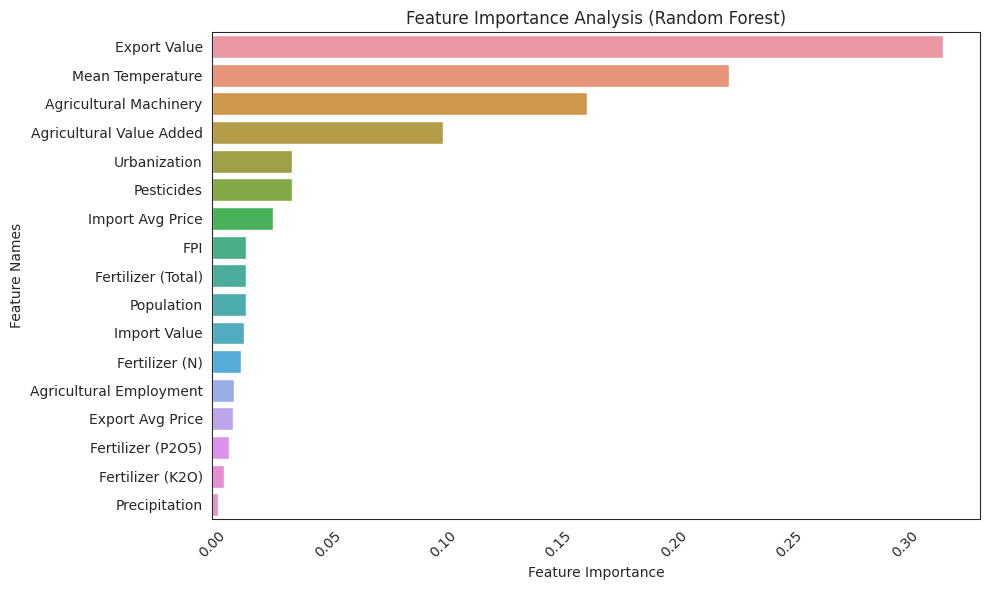

In [ ]:
# Get feature importances
feature_importances = default_rf_model.feature_importances_

# Get the corresponding feature names
feature_names = X_train.columns

# Sort indices in descending order of importance
sorted_indices = feature_importances.argsort()[::-1]

feature_importance_dict = {'Feature Importance': feature_importances[sorted_indices],
        'Feature Name': feature_names[sorted_indices]}

feature_importance_df = pd.DataFrame(feature_importance_dict)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x = feature_importances[sorted_indices], y=feature_names[sorted_indices])
plt.title("Feature Importance Analysis (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(file_path + 'plot/feature_importance_analysis.png')

In [ ]:
model_performance_metrics(model = default_rf_model, val_X = X_train, val_y = y_train), model_performance_metrics(model = default_rf_model, val_X = X_test, val_y = y_test)

({'MSE': 80.94792197958043,
  'MAPE': 0.11912695961586112,
  'RMSE': 8.997106311452612,
  'MAE': 3.9860990379137426,
  'R2': 0.9953350872991846},
 {'MSE': 404.3685157080963,
  'MAPE': 0.321851623658942,
  'RMSE': 20.10891632356394,
  'MAE': 9.461534149432282,
  'R2': 0.9658986485742631})

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Create and train the model
default_knn_model = KNeighborsRegressor(n_neighbors = 5)
default_knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
joblib.dump(default_knn_model, file_path + 'default_knn_model.pkl')

['drive/MyDrive/Modelling/default_knn_model.pkl']

In [ ]:
model_performance_metrics(model = default_knn_model, val_X = X_train, val_y = y_train), model_performance_metrics(model = default_knn_model, val_X = X_test, val_y = y_test)

({'MSE': 501.448708869927,
  'MAPE': 0.2380401746112654,
  'RMSE': 22.393050459236832,
  'MAE': 8.832196650738535,
  'R2': 0.9705110558636614},
 {'MSE': 549.1004786154119,
  'MAPE': 0.33612345671873983,
  'RMSE': 23.4328930910251,
  'MAE': 10.812273614413044,
  'R2': 0.9549153712670084})

### MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
default_mlp_model = Sequential()

# Add the input layer
default_mlp_model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

# Add the output layer
default_mlp_model.add(Dense(1))

# Compile the model
default_mlp_model.compile(optimizer='adam', loss='mse')

# Compile the model
default_mlp_model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
history = default_mlp_model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/100
39/39 [==============================] - 1s 7ms/step - loss: 25422.1699 - val_loss: 22155.0273
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 25049.3145 - val_loss: 21752.5039
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 24530.1445 - val_loss: 21208.7227
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 23827.5703 - val_loss: 20463.1934
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 22893.2402 - val_loss: 19555.0254
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 21775.9043 - val_loss: 18406.8457
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 20459.7910 - val_loss: 17175.9492
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 19025.8496 - val_loss: 15917.5039
Epoch 9/100
39/39 [==============================] - 0s 3ms/step - loss: 17582.8516 - val_loss: 14636.9951
Epoch 10/100
39/39 [=================

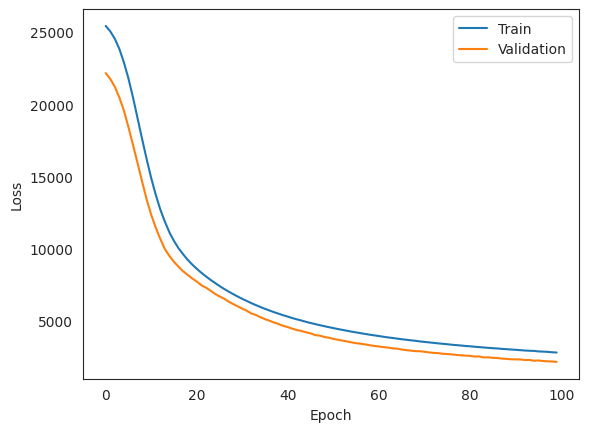

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(file_path + '/plot/default_mlp_training.png')

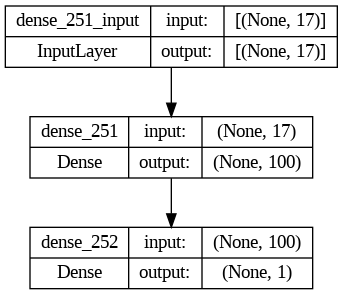

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(default_mlp_model, to_file= file_path + 'plot/default_mlp_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
default_mlp_model.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 100)               1800      
                                                                 
 dense_252 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,901
Trainable params: 1,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.models import save_model

# Save the trained model
default_mlp_model.save(file_path + 'default_mlp_model.h5')

In [ ]:
model_performance_metrics(model = default_mlp_model, val_X = X_train, val_y = y_train), model_performance_metrics(model = default_mlp_model, val_X = X_test, val_y = y_test)

11/11 [==============================] - 0s 2ms/step


({'MSE': 2722.3047407278987,
  'MAPE': 2.1289082618940602,
  'RMSE': 52.17571025609425,
  'MAE': 35.23631346630997,
  'R2': 0.8070647508536449},
 {'MSE': 2449.6040307774683,
  'MAPE': 2.6069592143772553,
  'RMSE': 49.49347462825244,
  'MAE': 34.035477858802366,
  'R2': 0.7563843351786045})

### Model Performance (default)

In [ ]:
# Initalizae a df to record performance matric
model_performance_train = pd.DataFrame(columns=['Model', 'MSE', 'MAPE', 'RMSE', 'MAE', 'R2'])
model_performance_test = pd.DataFrame(columns=['Model', 'MSE', 'MAPE', 'RMSE', 'MAE', 'R2'])



model_name_lst = ['xgboost', 'rf', 'knn', 'mlp']

# [locals()['default_' + model + '_model'] for model in model_name_lst]

for model_name in model_name_lst:
  model = locals()['default_' + model_name + '_model']


  train_performance = {**{'Model': model_name}, **model_performance_metrics(model = model, val_X = X_train, val_y = y_train)}
  test_performance = {**{'Model': model_name}, **model_performance_metrics(model = model, val_X = X_test, val_y = y_test)}

  model_performance_train = pd.concat([model_performance_train, pd.DataFrame([train_performance])], ignore_index=True)
  model_performance_test = pd.concat([model_performance_test, pd.DataFrame([test_performance])], ignore_index=True)

print('\nTraining Performance:')
display(model_performance_train)

print('\nTesting Performance:')
display(model_performance_test)

11/11 [==============================] - 0s 2ms/step

Training Performance:


,Model,MSE,MAPE,RMSE,MAE,R2
0,xgboost,2.492475,0.063229,1.578757,1.112643,0.999860
1,rf,80.947922,0.119127,8.997106,3.986099,0.995335
2,knn,501.448709,0.238040,22.393050,8.832197,0.970511
3,mlp,2722.304741,2.128908,52.175710,35.236313,0.807065



Testing Performance:


,Model,MSE,MAPE,RMSE,MAE,R2
0,xgboost,554.703941,0.326239,23.552154,9.870754,0.953595
1,rf,404.368516,0.321852,20.108916,9.461534,0.965899
2,knn,549.100479,0.336123,23.432893,10.812274,0.954915
3,mlp,2449.604031,2.606959,49.493475,34.035478,0.756384


In [ ]:
model_performance_train.to_csv(file_path + 'default_model_performance_train.csv', index = False)
model_performance_test.to_csv(file_path + 'default_model_performance_test.csv', index = False)

## Hyperparameter Tuning

In [ ]:
X_train_selected = X_train.drop(['Export Avg Price', 'Agricultural Employment'], axis = 1)
X_test_selected = X_test.drop(['Export Avg Price', 'Agricultural Employment'], axis = 1)

In [ ]:
X_train_selected.shape

(1383, 15)

### XGBoost

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of boosting rounds (trees)
    'max_depth': [3, 5, 7],             # Maximum depth of each tree
    'learning_rate': [0.1, 0.01, 0.001],# Step size shrinkage to prevent overfitting
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting trees
}

# Create the model
model = xgb.XGBRegressor()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator= model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv = 5)

grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters found during the search
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model and its predictions on the test set
best_xgboost_model = grid_search.best_estimator_

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
# Save the best model using joblib
joblib.dump(best_xgboost_model, file_path + 'best_xgboost_model.pkl')

['drive/MyDrive/Modelling/best_xgboost_model.pkl']

In [ ]:
# best_xgboost_model = joblib.load(file_path + 'best_xgboost_model.pkl')

In [ ]:
model_performance_metrics(model = best_xgboost_model, val_X = X_train_selected, val_y = y_train), model_performance_metrics(model = best_xgboost_model, val_X = X_test_selected, val_y = y_test)

({'MSE': 7.121224131843173,
  'MAPE': 0.1132179095455016,
  'RMSE': 2.6685621843687986,
  'MAE': 1.934194650244677,
  'R2': 0.9995995031207936},
 {'MSE': 477.8245618277084,
  'MAPE': 0.3862917952959762,
  'RMSE': 21.85919856325269,
  'MAE': 10.172884121762014,
  'R2': 0.9597629471689425})

### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [None, 5, 10],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
}

# Create the model
model = RandomForestRegressor()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv = 5)

grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters found during the search
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model and its predictions on the test set
best_rf_model = grid_search.best_estimator_

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Save the best model using joblib
joblib.dump(best_rf_model, file_path + 'best_rf_model.pkl')

['drive/MyDrive/Modelling/best_rf_model.pkl']

In [ ]:
# best_rf_model = joblib.load(file_path + 'best_rf_model.pkl')

In [ ]:
model_performance_metrics(model = best_rf_model, val_X = X_train_selected, val_y = y_train), model_performance_metrics(model = best_rf_model, val_X = X_test_selected, val_y = y_test)

({'MSE': 67.66028896763206,
  'MAPE': 0.12164555091408193,
  'RMSE': 8.225587454257116,
  'MAE': 3.7951002805021,
  'R2': 0.9961038321212023},
 {'MSE': 403.0930517013388,
  'MAPE': 0.33026554721802587,
  'RMSE': 20.07717738381914,
  'MAE': 9.634934586732175,
  'R2': 0.9659150078433043})

#### Feature Importance Analysis

    Feature Importance              Feature Name
0             0.322120              Export Value
1             0.216056          Mean Temperature
2             0.181277    Agricultural Machinery
3             0.098398  Agricultural Value Added
4             0.033912              Urbanization
5             0.031642                Pesticides
6             0.028471          Import Avg Price
7             0.016584        Fertilizer (Total)
8             0.014439                Population
9             0.014019              Import Value
10            0.013760                       FPI
11            0.011277            Fertilizer (N)
12            0.008862         Fertilizer (P2O5)
13            0.006519          Fertilizer (K2O)
14            0.002665             Precipitation


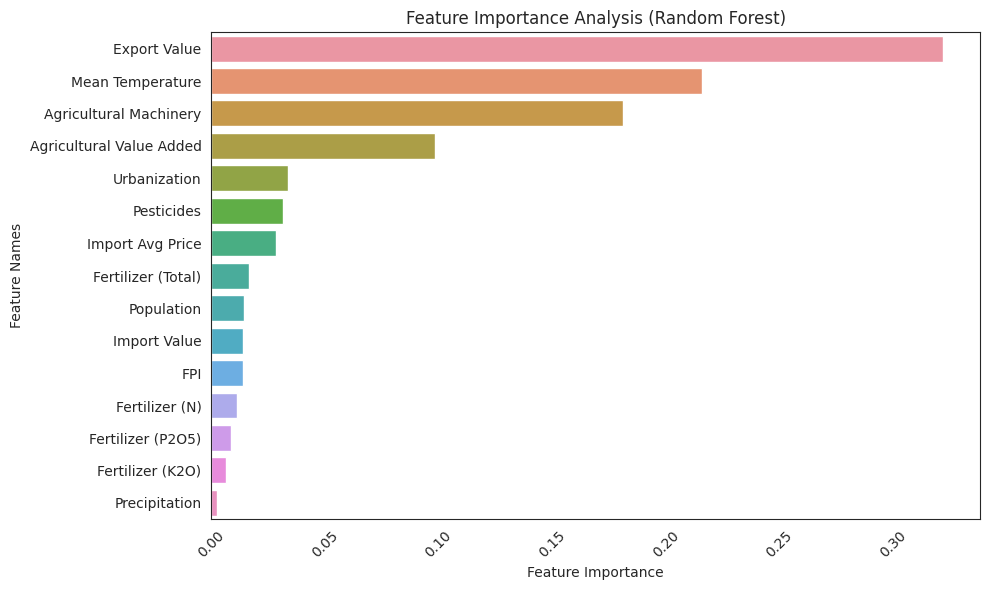

In [ ]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Get the corresponding feature names
feature_names = X_train_selected.columns

# Sort indices in descending order of importance
sorted_indices = feature_importances.argsort()[::-1]

feature_importance_dict = {'Feature Importance': feature_importances[sorted_indices],
        'Feature Name': feature_names[sorted_indices]}

feature_importance_df = pd.DataFrame(feature_importance_dict)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x = feature_importances[sorted_indices], y=feature_names[sorted_indices])
plt.title("Feature Importance Analysis (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(file_path + 'plot/feature_importance_analysis.png')

### kNN

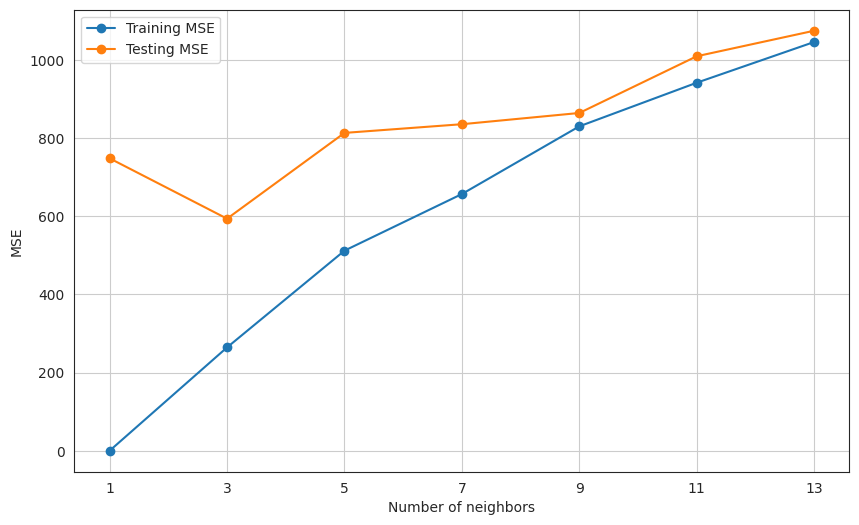

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Empty lists to store the MSE values for each k
train_errors = []
test_errors = []

# For each number of neighbors

# neighbors = list(range(15))[1:]
neighbors = [1, 3, 5, 7, 9, 11, 13]

for k in neighbors:
    # Create and train the model
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train_selected, y_train)

    # Predict on the training set and calculate the MSE
    train_pred = knn.predict(X_train_selected)
    train_mse = mse(y_train, train_pred)
    train_errors.append(train_mse)

    # Predict on the testing set and calculate the MSE
    test_pred = knn.predict(X_test_selected)
    test_mse = mse(y_test, test_pred)
    test_errors.append(test_mse)

# Convert the number of neighbors to strings for plotting
neighbors_str = [str(k) for k in neighbors]

# Plot the training and testing MSE for each number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_str, train_errors, label='Training MSE', marker = 'o')
plt.plot(neighbors_str, test_errors, label='Testing MSE', marker = 'o')
plt.xlabel('Number of neighbors')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(file_path + 'plot/knn_training.png')

In [ ]:
best_k = neighbors_str[test_errors.index(min(test_errors))]
print("Minimum MSE:", min(test_errors))
print("Best parameters:", best_k)

Minimum MSE: 594.0557443405573
Best parameters: 3


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],  # Number of neighbors to consider
    'p': [1, 2],                              # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Create the KNN regressor
knn = KNeighborsRegressor()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10)  # Use a suitable number of CV folds

grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters found during the search
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model and its predictions on the test set
best_knn_model = grid_search.best_estimator_


Best hyperparameters: {'n_neighbors': 3, 'p': 1}


In [ ]:
joblib.dump(best_knn_model, file_path + 'best_knn_model.pkl')

['drive/MyDrive/Modelling/best_knn_model.pkl']

In [ ]:
model_performance_metrics(model = best_knn_model, val_X = X_train_selected, val_y = y_train), model_performance_metrics(model = best_knn_model, val_X = X_test_selected, val_y = y_test)

({'MSE': 199.54031564447536,
  'MAPE': 0.12500614676774385,
  'RMSE': 14.12587397807567,
  'MAE': 6.1937564470595055,
  'R2': 0.9887936984349175},
 {'MSE': 278.18162231879444,
  'MAPE': 0.2387971157557426,
  'RMSE': 16.67877760265405,
  'MAE': 8.47360839130241,
  'R2': 0.9781605011304888})

### MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from keras.optimizers import Adam

In [ ]:
def create_model(num_hidden_layer = None, hidden_layer_size=None, dropout_rate = None):
  model = Sequential()

  # hidden layers
  for _ in range(num_hidden_layer):
    model.add(Dense(hidden_layer_size,
                activation='relu',
                input_shape=(X_train.shape[1],),
                kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))

  model.add(Dense(1))

  return model

In [ ]:
# Create the parameter grid for tuning
num_hidden_layer = [1, 2, 3]
hidden_layer_size = [50, 100]
dropout_rate = [0, 0.2, 0.4]
learning_rate = [0.001, 0.01, 0.1]
batch_size = [32, 64]

param_grid = [{'num_hidden_layer': num_layer,
               'hidden_layer_size': layer_size,
               'dropout_rate': rate,
               'learning_rate': lr,
               'batch_size': bs}
              for num_layer in num_hidden_layer
              for layer_size in hidden_layer_size
              for rate in dropout_rate
              for lr in learning_rate
              for bs in batch_size]

In [ ]:
# Define the number of repetitions
num_repetitions = 3

mse_avg_lst = []

for param in param_grid:
    mse_error_list = []

    for _ in range(num_repetitions):
        model = create_model(num_hidden_layer=param['num_hidden_layer'],
                             hidden_layer_size=param['hidden_layer_size'],
                             dropout_rate=param['dropout_rate'])

        # Compile the model with the specified learning rate
        model.compile(optimizer=Adam(learning_rate=param['learning_rate']), loss='mse')

        # Fit the model to the training data with the specified batch size and epochs
        history = model.fit(X_train, y_train, epochs = 50, batch_size=param['batch_size'], verbose=0, validation_split=0.1)

        # Make predictions on the test set
        preds = model.predict(X_train)

        # Compute MSE error
        mse_error = mse(y_train, preds)

        mse_error_list.append(mse_error)

    # Calculate the average MSE for this combination of hyperparameters
    mse_avg = np.mean(mse_error_list)
    mse_avg_lst.append(mse_avg)

# Find the hyperparameters with the lowest average MSE
best_params_idx = np.argmin(mse_avg_lst)
best_params = param_grid[best_params_idx]
best_avg_mse = mse_avg_lst[best_params_idx]

# Print the best hyperparameters and the corresponding average MSE
print("Best hyperparameters:", best_params)
print("Average MSE:", best_avg_mse)

44/44 [==============================] - 0s 2ms/step
Best hyperparameters: {'num_hidden_layer': 3, 'hidden_layer_size': 100, 'dropout_rate': 0, 'learning_rate': 0.01, 'batch_size': 32}
Average MSE: 310.77591558883597


In [ ]:
# Print the best hyperparameters and the corresponding average MSE
print("Best hyperparameters:", best_params)
print("Average MSE:", best_avg_mse)

Best hyperparameters: {'num_hidden_layer': 3, 'hidden_layer_size': 100, 'dropout_rate': 0, 'learning_rate': 0.01, 'batch_size': 32}
Average MSE: 310.77591558883597


In [ ]:
# Make predictions on the best model

best_mlp_model = create_model(num_hidden_layer = best_params['num_hidden_layer'],
                       hidden_layer_size= best_params['hidden_layer_size'], dropout_rate = best_params['dropout_rate'])


# Compile the model with the specified learning rate
best_mlp_model.compile(optimizer = Adam(learning_rate=best_params['learning_rate']), loss='mse')

# Fit the model to the training data with the specified batch size and epochs
history = best_mlp_model.fit(X_train, y_train, epochs= 50, batch_size=best_params['batch_size'], verbose=0, validation_split=0.1)

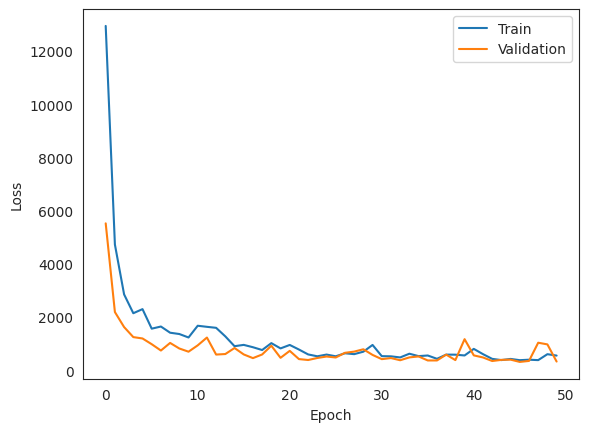

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(file_path + '/plot/best_mlp_training.png')

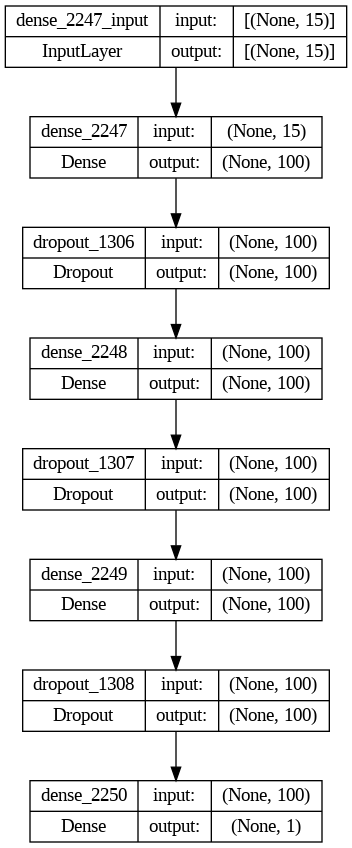

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(best_mlp_model, to_file= file_path + 'plot/best_mlp_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
best_mlp_model.summary()

Model: "sequential_752"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2259 (Dense)          (None, 100)               1600      
                                                                 
 dropout_1315 (Dropout)      (None, 100)               0         
                                                                 
 dense_2260 (Dense)          (None, 100)               10100     
                                                                 
 dropout_1316 (Dropout)      (None, 100)               0         
                                                                 
 dense_2261 (Dense)          (None, 100)               10100     
                                                                 
 dropout_1317 (Dropout)      (None, 100)               0         
                                                                 
 dense_2262 (Dense)          (None, 1)              

In [ ]:
from keras.models import save_model

# Save the trained model
best_mlp_model.save(file_path + 'best_mlp_model.h5')

In [ ]:
from keras.models import load_model

# Load the saved model
best_mlp_model = load_model(file_path + 'best_mlp_model.h5')

In [ ]:
model_performance_metrics(model = best_mlp_model, val_X = X_train_selected, val_y = y_train), model_performance_metrics(model = best_mlp_model, val_X = X_test_selected, val_y = y_test)

11/11 [==============================] - 0s 2ms/step


({'MSE': 261.5897427078875,
  'MAPE': 0.3826680535921939,
  'RMSE': 16.173736201258123,
  'MAE': 9.458093814113363,
  'R2': 0.9847077597204453},
 {'MSE': 560.4112913768481,
  'MAPE': 0.6278743630275697,
  'RMSE': 23.673007653799466,
  'MAE': 12.259830931459927,
  'R2': 0.954548777757582})

## Tuned Model Performance

In [ ]:
best_mlp_model = load_model()

In [ ]:
# Initalizae a df to record performance matric
model_performance_train = pd.DataFrame(columns=['Model', 'MSE', 'MAPE', 'RMSE', 'MAE', 'R2'])
model_performance_test = pd.DataFrame(columns=['Model', 'MSE', 'MAPE', 'RMSE', 'MAE', 'R2'])

model_name_lst = ['xgboost', 'rf', 'knn', 'mlp']


for model_name in model_name_lst:
  model = locals()['best_' + model_name + '_model']

  print(1)
  train_performance = {**{'Model': model_name}, **model_performance_metrics(model = model, val_X = X_train_selected, val_y = y_train)}
  test_performance = {**{'Model': model_name}, **model_performance_metrics(model = model, val_X = X_test_selected, val_y = y_test)}

  model_performance_train = pd.concat([model_performance_train, pd.DataFrame([train_performance])], ignore_index=True)
  model_performance_test = pd.concat([model_performance_test, pd.DataFrame([test_performance])], ignore_index=True)

print('\nTraining Performance:')
display(model_performance_train)

print('\nTesting Performance:')
display(model_performance_test)

In [ ]:
model_performance_train.to_csv(file_path + 'best_model_performance_train.csv', index = False)
model_performance_test.to_csv(file_path + 'best_model_performance_test.csv', index = False)

# Load Tuned Models

In [ ]:
from keras.models import load_model

In [ ]:
for model_file in ['default_xgboost_model.pkl',
 'default_rf_model.pkl',
 'default_knn_model.pkl',
 'default_mlp_model.h5',
 'best_knn_model.pkl',
 'best_mlp_model.h5',
 'best_rf_model.pkl',
 'best_xgboost_model.pkl']:

 if model_file.endswith('pkl'):
  locals()[model_file.split('.')[0]] = joblib.load(file_path + model_file)

 elif model_file.endswith('h5'):
  locals()[model_file.split('.')[0]] = load_model(file_path + model_file)

In [ ]:
best_rf_model.predict(X_train_selected)

array([ 30.29772302, 592.13759758,  12.09172958, ..., 324.22376335,
        30.19484462,  39.0216678 ])

In [ ]:
model_name_lst = ['xgboost', 'rf', 'knn', 'mlp']

for model_name in model_name_lst:
  model = locals()['best_' + model_name + '_model']

  print(1)

  locals()[model_name + '_pred_train'] = model.predict(X_train_selected).flatten()
  locals()[model_name + '_pred_test'] = model.predict(X_test_selected).flatten()

1
1
1
1
11/11 [==============================] - 0s 2ms/step


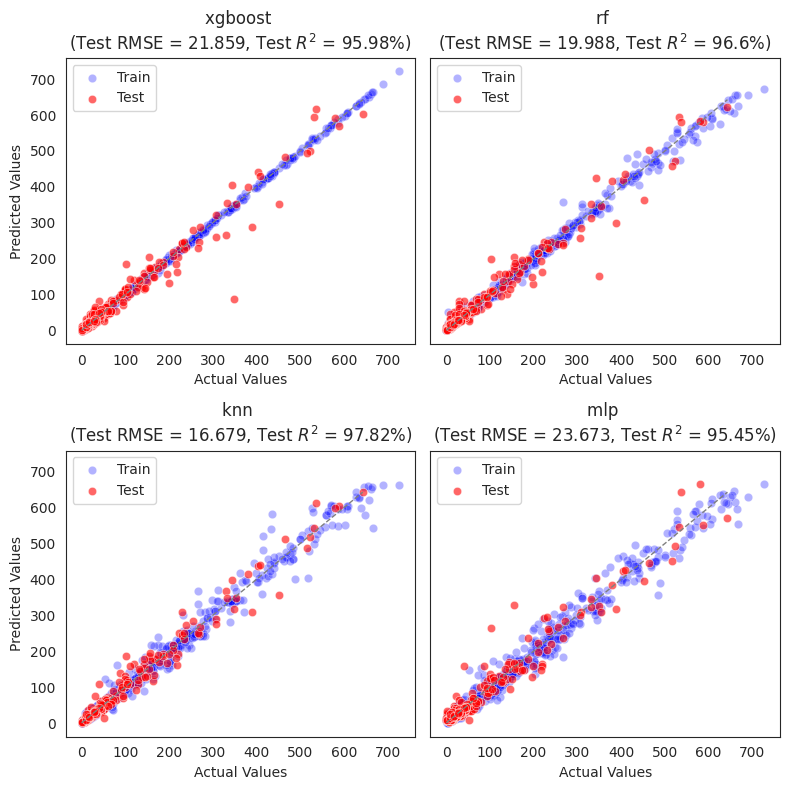

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
ax = ax.flatten()

preds_test = [xgboost_pred_test, rf_pred_test, knn_pred_test, mlp_pred_test]
preds_train = [xgboost_pred_train, rf_pred_train, knn_pred_train, mlp_pred_train]

for idx, pred in enumerate(preds_test):
    sns.scatterplot(x=y_train.values, y=preds_train[idx], ax=ax[idx], color='blue', alpha=0.3, label='Train')
    sns.scatterplot(x=y_test.values, y=preds_test[idx], ax=ax[idx], color='red', alpha=0.6, label='Test')

    ax[idx].plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)],
                 color='grey', linestyle='--', linewidth=1)

    RMSE = round(best_model_performance_test.loc[idx, 'RMSE'], 3)
    R2 = str(round(best_model_performance_test.loc[idx, 'R2'] * 100, 2)) + "%"
    Model_Name = best_model_performance_test.loc[idx, 'Model']

    ax[idx].set_title(f'{Model_Name} \n(Test RMSE = {RMSE}, Test $R^2$ = {R2})')

    ax[idx].set_xlabel('Actual Values')
    ax[idx].set_ylabel('Predicted Values')

plt.tight_layout()
plt.savefig(file_path + 'plot/model_performance_scatter.png')

# Final Performance

In [ ]:
default_model_performance_train = pd.read_csv(file_path + 'default_model_performance_train.csv')
print(default_model_performance_train, '\n')

default_model_performance_test = pd.read_csv(file_path + 'default_model_performance_test.csv')
print(default_model_performance_test, '\n')

best_model_performance_train = pd.read_csv(file_path + 'best_model_performance_train.csv')
print(best_model_performance_train, '\n')

best_model_performance_test = pd.read_csv(file_path + 'best_model_performance_test.csv')
print(best_model_performance_test, '\n')

     Model          MSE      MAPE       RMSE        MAE        R2
0  xgboost     2.492475  0.063229   1.578757   1.112643  0.999860
1       rf    80.947922  0.119127   8.997106   3.986099  0.995335
2      knn   501.448709  0.238040  22.393050   8.832197  0.970511
3      mlp  2722.304741  2.128908  52.175710  35.236313  0.807065 

     Model          MSE      MAPE       RMSE        MAE        R2
0  xgboost   554.703941  0.326239  23.552154   9.870754  0.953595
1       rf   404.368516  0.321852  20.108916   9.461534  0.965899
2      knn   549.100479  0.336123  23.432893  10.812274  0.954915
3      mlp  2449.604031  2.606959  49.493475  34.035478  0.756384 

     Model         MSE      MAPE       RMSE       MAE        R2
0  xgboost    7.121224  0.113218   2.668562  1.934195  0.999600
1       rf   70.619645  0.116960   8.403550  3.789865  0.995925
2      knn  199.540316  0.125006  14.125874  6.193756  0.988794
3      mlp  261.589743  0.382668  16.173736  9.458094  0.984708 

     Model    

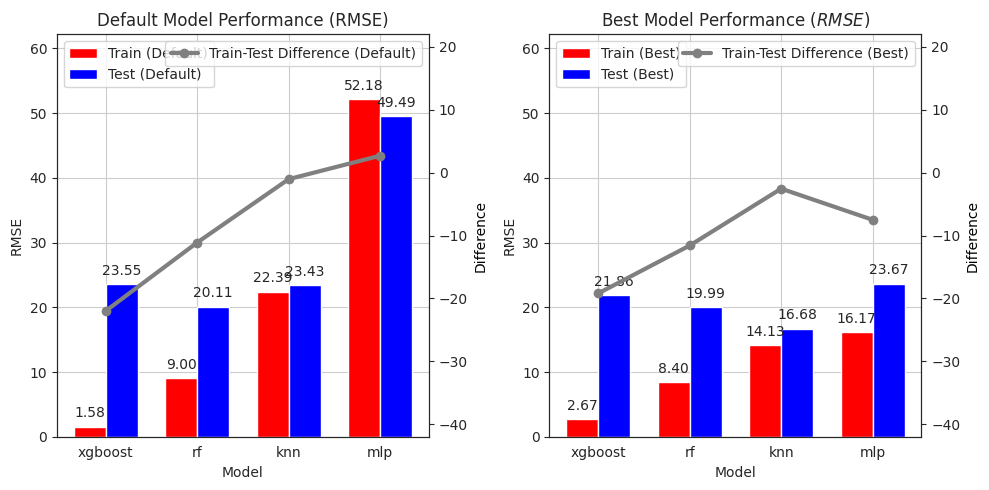

In [ ]:
combined_data_default = pd.merge(default_model_performance_train, default_model_performance_test, on="Model", suffixes=("_Train", "_Test"))

combined_data_best = pd.merge(best_model_performance_train, best_model_performance_test, on="Model", suffixes=("_Train", "_Test"))

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

bar_width = 0.35
index = np.arange(len(combined_data_default))

# Plot for Default models (Bar)
bar1_default = ax[0].bar(index - bar_width/2, combined_data_default['RMSE_Train'], bar_width, label='Train (Default)', color='red')
bar2_default = ax[0].bar(index + bar_width/2, combined_data_default['RMSE_Test'], bar_width, label='Test (Default)', color='blue')

# Plot for Best models (Bar)
bar1_best = ax[1].bar(index - bar_width/2, combined_data_best['RMSE_Train'], bar_width, label='Train (Best)', color='red')
bar2_best = ax[1].bar(index + bar_width/2, combined_data_best['RMSE_Test'], bar_width, label='Test (Best)', color='blue')

# Set a common y-axis limit for both bar plots
max_y_bar = max(combined_data_default['RMSE_Train'].max(), combined_data_default['RMSE_Test'].max(),
                combined_data_best['RMSE_Train'].max(), combined_data_best['RMSE_Test'].max())
ax[0].set_ylim(0, max_y_bar + 10)
ax[1].set_ylim(0, max_y_bar + 10)

# Calculate the maximum Train-Test Difference across both datasets
max_diff_default = max(abs(combined_data_default['RMSE_Train'] - combined_data_default['RMSE_Test']))
max_diff_best = max(abs(combined_data_best['RMSE_Train'] - combined_data_best['RMSE_Test']))
max_diff = max(max_diff_default, max_diff_best)

# Create a twin y-axis for the line plot (Train-Test Difference)
ax2_default = ax[0].twinx()
ax2_best = ax[1].twinx()

# Plot for Default models (Line)
ax2_default.plot(index, combined_data_default['RMSE_Train'] - combined_data_default['RMSE_Test'], marker='o', color='grey', label='Train-Test Difference (Default)', linewidth = 3)
ax2_default.set_ylabel('Difference', color='black')
ax2_default.set_ylim(-max_diff-20, max_diff)  # Set the same y-axis limit for Train-Test Difference
ax2_default.legend(loc='upper right')

# Plot for Best models (Line)
ax2_best.plot(index, combined_data_best['RMSE_Train'] - combined_data_best['RMSE_Test'], marker='o', color='grey', label='Train-Test Difference (Best)', linewidth = 3)
ax2_default.set_ylabel('Difference', color='black')
ax2_best.set_ylabel('Difference', color='black')
ax2_best.set_ylim(-max_diff-20, max_diff)  # Set the same y-axis limit for Train-Test Difference
ax2_best.legend(loc='upper right')

# Add annotations for Default models (Bar)
for i, (d_train, d_test) in enumerate(zip(combined_data_default['RMSE_Train'], combined_data_default['RMSE_Test'])):
    ax[0].text(index[i] - bar_width / 2, d_train + 1, f"{d_train:.2f}", ha='center', va='bottom')
    ax[0].text(index[i] + bar_width / 2, d_test + 1, f"{d_test:.2f}", ha='center', va='bottom')

# Add annotations for Best models (Bar)
for i, (b_train, b_test) in enumerate(zip(combined_data_best['RMSE_Train'], combined_data_best['RMSE_Test'])):
    ax[1].text(index[i] - bar_width / 2, b_train + 1, f"{b_train:.2f}", ha='center', va='bottom')
    ax[1].text(index[i] + bar_width / 2, b_test + 1, f"{b_test:.2f}", ha='center', va='bottom')

ax[0].set_xlabel('Model')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Default Model Performance (RMSE)')
ax[0].set_xticks(index)
ax[0].set_xticklabels(combined_data_default['Model'])
ax[0].grid()
ax[0].legend(loc='upper left')

ax[1].set_xlabel('Model')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Best Model Performance (RMSE)')
ax[1].set_xticks(index)
ax[1].set_xticklabels(combined_data_best['Model'])
ax[1].grid()
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.savefig(file_path + 'plot/rmse_bar_plot.png')

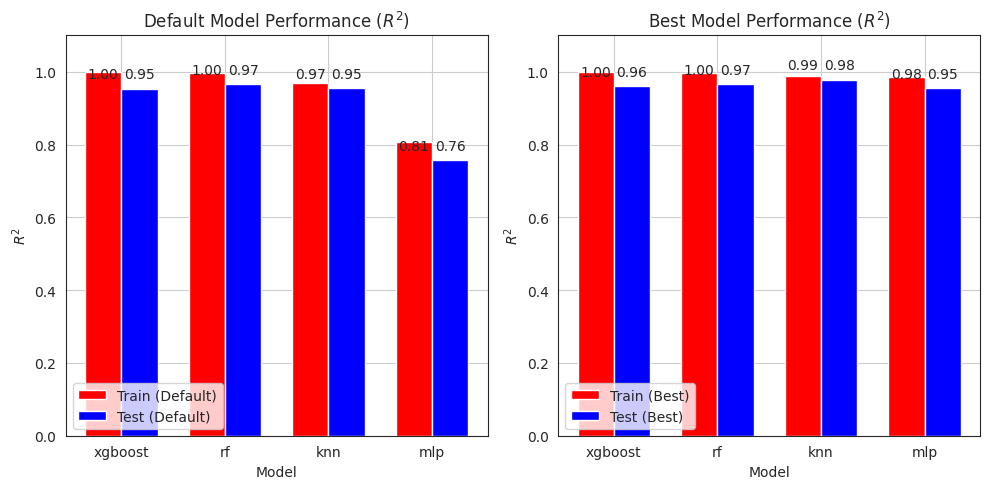

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

bar_width = 0.35
index = np.arange(len(combined_data_default))

# Plot for Default models (Bar)
bar1_default = ax[0].bar(index - bar_width/2, combined_data_default['R2_Train'], bar_width, label='Train (Default)', color='red')
bar2_default = ax[0].bar(index + bar_width/2, combined_data_default['R2_Test'], bar_width, label='Test (Default)', color='blue')

# Plot for Best models (Bar)
bar1_best = ax[1].bar(index - bar_width/2, combined_data_best['R2_Train'], bar_width, label='Train (Best)', color='red')
bar2_best = ax[1].bar(index + bar_width/2, combined_data_best['R2_Test'], bar_width, label='Test (Best)', color='blue')


# Set a common y-axis limit for both bar plots
max_y_bar = max(combined_data_default['R2_Train'].max(), combined_data_default['R2_Test'].max(),
                combined_data_best['R2_Train'].max(), combined_data_best['R2_Test'].max())
ax[0].set_ylim(0, max_y_bar + 0.1)
ax[1].set_ylim(0, max_y_bar + 0.1)

# Add annotations for Default models (Bar)
for i, (d_train, d_test) in enumerate(zip(combined_data_default['R2_Train'], combined_data_default['R2_Test'])):
    ax[0].text(index[i] - bar_width / 2, min(d_train, d_test) + 0.02, f"{d_train:.2f}", ha='center', va='bottom')
    ax[0].text(index[i] + bar_width / 2, min(d_train, d_test) + 0.02, f"{d_test:.2f}", ha='center', va='bottom')

# Add annotations for Best models (Bar)
for i, (b_train, b_test) in enumerate(zip(combined_data_best['R2_Train'], combined_data_best['R2_Test'])):
    ax[1].text(index[i] - bar_width / 2, min(b_train, b_test) + 0.02, f"{b_train:.2f}", ha='center', va='bottom')
    ax[1].text(index[i] + bar_width / 2, min(b_train, b_test) + 0.02, f"{b_test:.2f}", ha='center', va='bottom')

ax[0].set_xlabel('Model')
ax[0].set_ylabel('$R^2$')
ax[0].set_title('Default Model Performance ($R^2$)')
ax[0].set_xticks(index)
ax[0].set_xticklabels(combined_data_default['Model'])
ax[0].grid()
ax[0].legend(loc='lower left')

ax[1].set_xlabel('Model')
ax[1].set_ylabel('$R^2$')
ax[1].set_title('Best Model Performance ($R^2$)')
ax[1].set_xticks(index)
ax[1].set_xticklabels(combined_data_best['Model'])
ax[1].grid()
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.savefig(file_path + 'plot/r2_bar_plot.png')

In [ ]:
list(range(2, 4))

[2, 3]

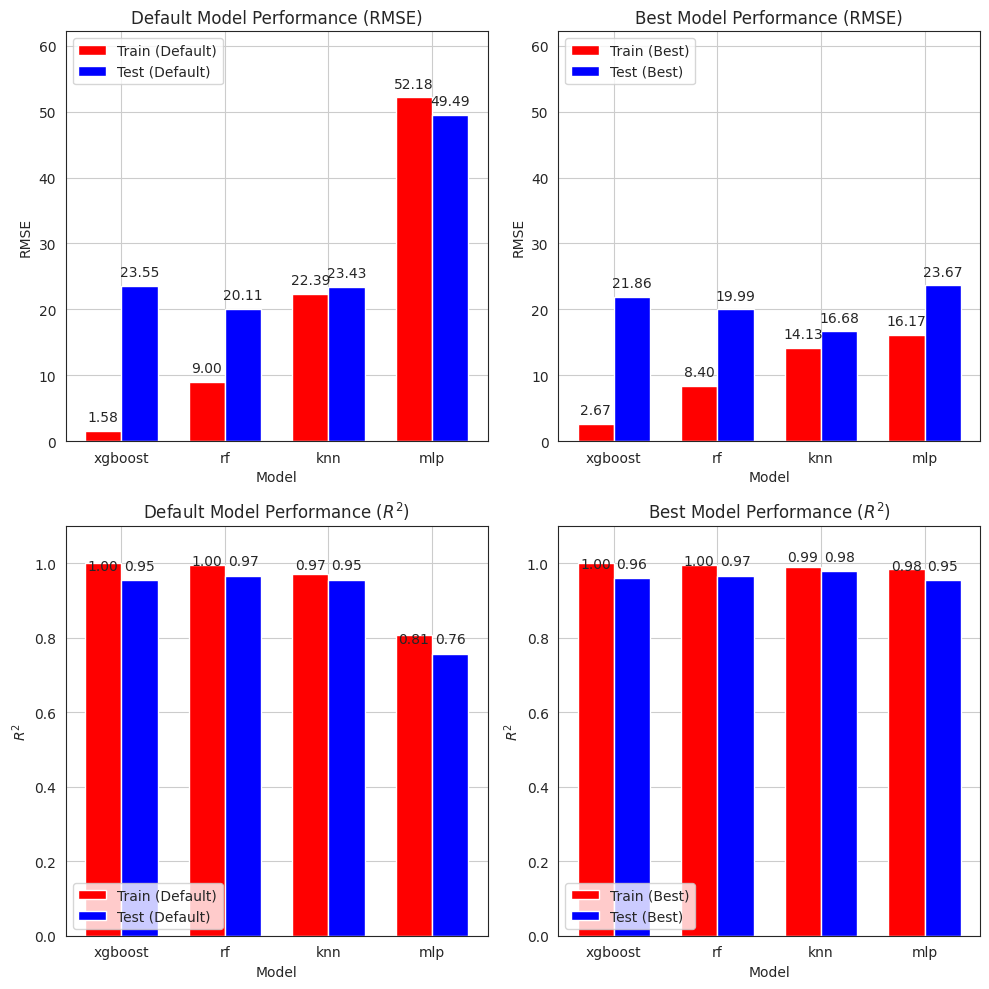

In [ ]:
combined_data_default = pd.merge(default_model_performance_train, default_model_performance_test, on="Model", suffixes=("_Train", "_Test"))
combined_data_best = pd.merge(best_model_performance_train, best_model_performance_test, on="Model", suffixes=("_Train", "_Test"))

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

# Define common variables for both sets of plots
bar_width = 0.35
index = np.arange(len(combined_data_default))

# Plot for Default RMSE models (Bar)
bar1_default_rmse = ax[0].bar(index - bar_width/2, combined_data_default['RMSE_Train'], bar_width, label='Train (Default)', color='red')
bar2_default_rmse = ax[0].bar(index + bar_width/2, combined_data_default['RMSE_Test'], bar_width, label='Test (Default)', color='blue')

# Plot for Best RMSE models (Bar)
bar1_best_rmse = ax[1].bar(index - bar_width/2, combined_data_best['RMSE_Train'], bar_width, label='Train (Best)', color='red')
bar2_best_rmse = ax[1].bar(index + bar_width/2, combined_data_best['RMSE_Test'], bar_width, label='Test (Best)', color='blue')

# Plot for Default R2 models (Bar)
bar1_default_r2 = ax[2].bar(index - bar_width/2, combined_data_default['R2_Train'], bar_width, label='Train (Default)', color='red')
bar2_default_r2 = ax[2].bar(index + bar_width/2, combined_data_default['R2_Test'], bar_width, label='Test (Default)', color='blue')

# Plot for Best R2 models (Bar)
bar1_best_r2 = ax[3].bar(index - bar_width/2, combined_data_best['R2_Train'], bar_width, label='Train (Best)', color='red')
bar2_best_r2 = ax[3].bar(index + bar_width/2, combined_data_best['R2_Test'], bar_width, label='Test (Best)', color='blue')

# Set common y-axis limits for all bar plots
max_y_bar_rmse = max(combined_data_default['RMSE_Train'].max(), combined_data_default['RMSE_Test'].max(),
                     combined_data_best['RMSE_Train'].max(), combined_data_best['RMSE_Test'].max())

max_y_bar_r2 = max(combined_data_default['R2_Train'].max(), combined_data_default['R2_Test'].max(),
                   combined_data_best['R2_Train'].max(), combined_data_best['R2_Test'].max())

# Set y-axis limits for RMSE plots
for i in range(2):  # Iterate over rows
    ax[i].set_ylim(0, max_y_bar_rmse + 10)

# Set y-axis limits for R2 plots
for i in range(2, 4):  # Iterate over rows
    ax[i].set_ylim(0, max_y_bar_r2 + 0.1)

# Set x-axis tick labels
for i in range(4):  # Iterate over rows
    ax[i].set_xticks(index)
    ax[i].set_xticklabels(combined_data_default['Model'])

# Add annotations for Default RMSE models (Bar)
for i, (d_train, d_test) in enumerate(zip(combined_data_default['RMSE_Train'], combined_data_default['RMSE_Test'])):
    ax[0].text(index[i] - bar_width / 2, d_train + 1, f"{d_train:.2f}", ha='center', va='bottom')
    ax[0].text(index[i] + bar_width / 2, d_test + 1, f"{d_test:.2f}", ha='center', va='bottom')

# Add annotations for Best RMSE models (Bar)
for i, (b_train, b_test) in enumerate(zip(combined_data_best['RMSE_Train'], combined_data_best['RMSE_Test'])):
    ax[1].text(index[i] - bar_width / 2, b_train + 1, f"{b_train:.2f}", ha='center', va='bottom')
    ax[1].text(index[i] + bar_width / 2, b_test + 1, f"{b_test:.2f}", ha='center', va='bottom')

# Add annotations for Default R2 models (Bar)
for i, (d_train, d_test) in enumerate(zip(combined_data_default['R2_Train'], combined_data_default['R2_Test'])):
    ax[2].text(index[i] - bar_width / 2, min(d_train, d_test) + 0.02, f"{d_train:.2f}", ha='center', va='bottom')
    ax[2].text(index[i] + bar_width / 2, min(d_train, d_test) + 0.02, f"{d_test:.2f}", ha='center', va='bottom')

# Add annotations for Best R2 models (Bar)
for i, (b_train, b_test) in enumerate(zip(combined_data_best['R2_Train'], combined_data_best['R2_Test'])):
    ax[3].text(index[i] - bar_width / 2, min(b_train, b_test) + 0.02, f"{b_train:.2f}", ha='center', va='bottom')
    ax[3].text(index[i] + bar_width / 2, min(b_train, b_test) + 0.02, f"{b_test:.2f}", ha='center', va='bottom')

# Set common x-axis labels and titles for all plots
for i in range(4):  # Iterate over rows
    ax[i].set_xlabel('Model')
    ax[i].grid()

# Set y-axis limits for RMSE plots
for i in range(2):  # Iterate over rows
    ax[i].legend(loc='upper left')

# Set y-axis limits for R2 plots
for i in range(2, 4):  # Iterate over rows
    ax[i].legend(loc='lower left')

ax[0].set_ylabel('RMSE')
ax[0].set_title('Default Model Performance (RMSE)')

ax[1].set_ylabel('RMSE')
ax[1].set_title('Best Model Performance (RMSE)')

ax[2].set_ylabel('$R^2$')
ax[2].set_title('Default Model Performance ($R^2$)')

ax[3].set_ylabel('$R^2$')
ax[3].set_title('Best Model Performance ($R^2$)')

# Adjust layout
plt.tight_layout()

plt.savefig(file_path + 'plot/model_performance_before_and_after.png')

In [ ]:
performance_by_year = pd.DataFrame()

performance_by_year['Year'] = [data.iloc[index]['Year'] for index in df_test.index]
performance_by_year['Yield'] = df_test['Yield'].values
performance_by_year['Yield_predicted'] = knn_pred_test

In [ ]:
# Calculate RMSE by country
rmse_by_year = performance_by_year.groupby('Year').apply(lambda x: np.sqrt(mse(x['Yield'], x['Yield_predicted'])))

# Sort RMSE values in ascending order
rmse_by_year = rmse_by_year.sort_index()

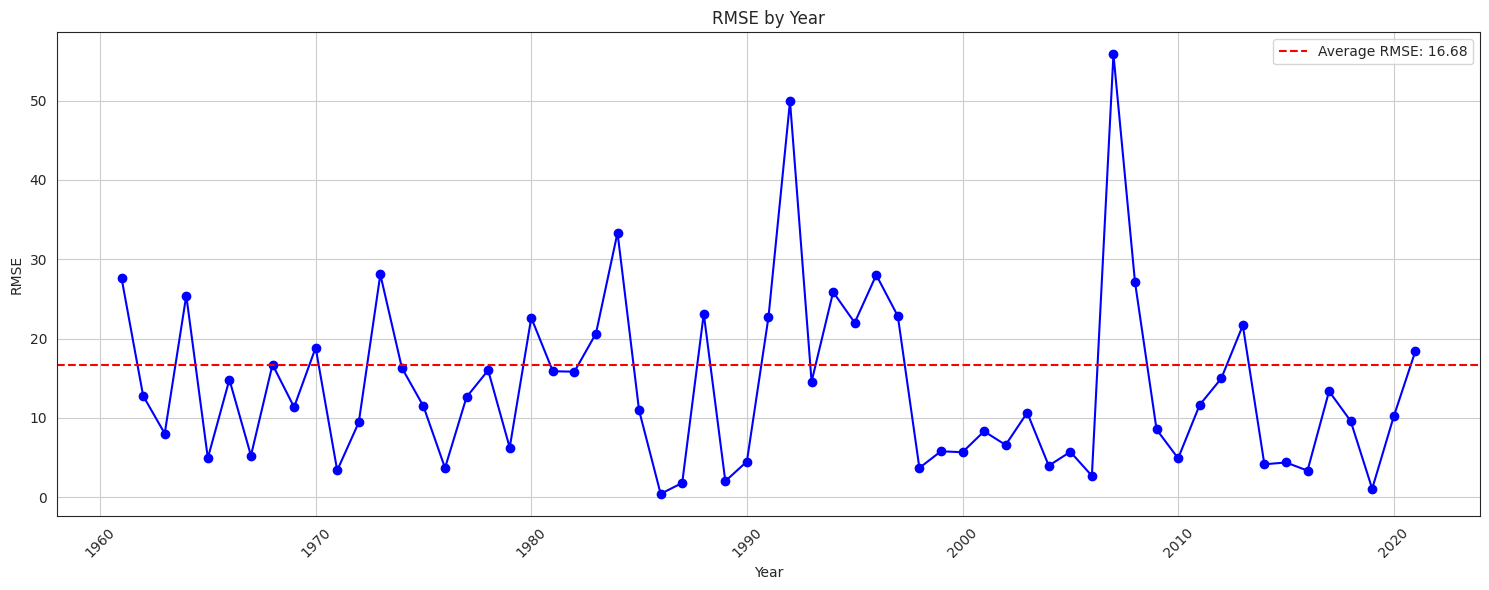

In [ ]:
# Calculate the average RMSE
average_rmse = best_model_performance_test.loc[best_model_performance_test['Model'] == 'knn', 'RMSE'].values[0]

# Plot RMSE by country
plt.figure(figsize=(15, 6))
ax = rmse_by_year.plot(color='blue', marker = 'o')
plt.axhline(y=average_rmse, color='red', linestyle='--', label=f'Average RMSE: {average_rmse:.2f}')
plt.title('RMSE by Year')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid()

plt.savefig(file_path + 'plot/rmse_year.png')

In [ ]:
performance_by_country = pd.DataFrame()

performance_by_country['Country'] = [data.iloc[index]['Country'] for index in df_test.index]
performance_by_country['Yield'] = df_test['Yield'].values
performance_by_country['Yield_predicted'] = knn_pred_test


In [ ]:
# Calculate RMSE by country
rmse_by_country = performance_by_country.groupby('Country').apply(lambda x: np.sqrt(mse(x['Yield'], x['Yield_predicted'])))

# Sort RMSE values in ascending order
rmse_by_country = rmse_by_country.sort_values(ascending=False)

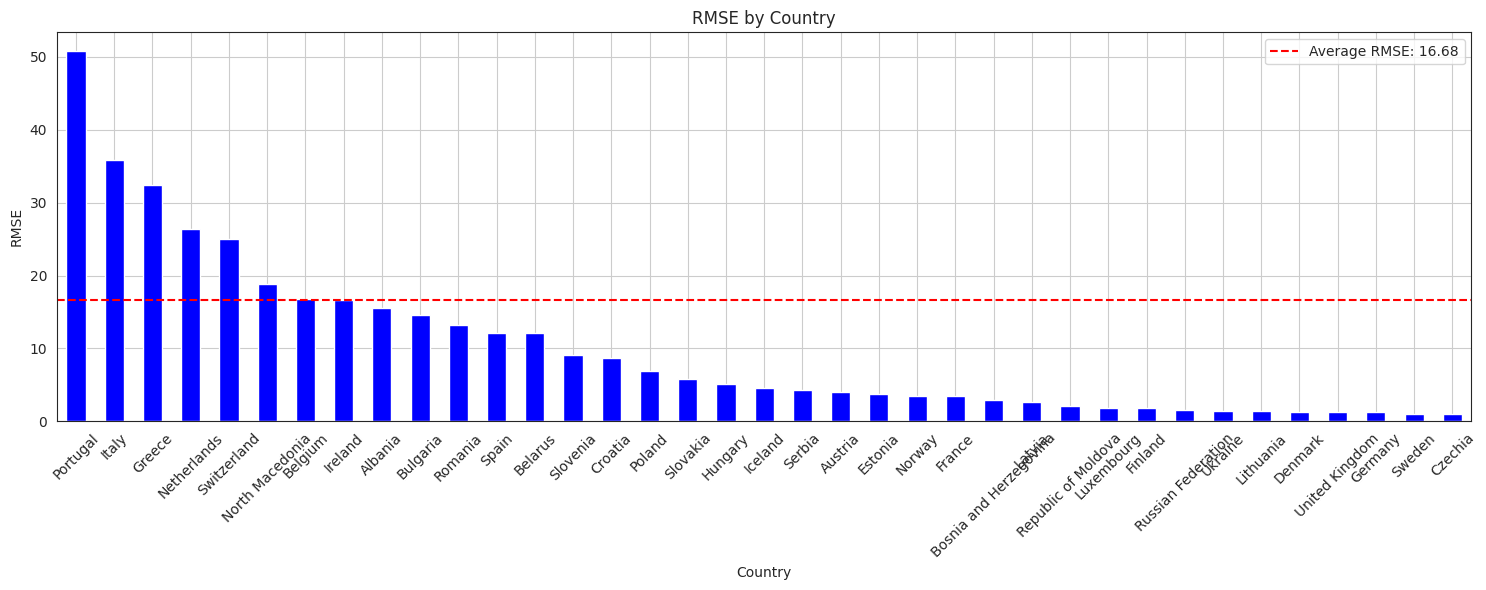

In [ ]:
# Calculate the average RMSE
average_rmse = best_model_performance_test.loc[best_model_performance_test['Model'] == 'knn', 'RMSE'].values[0]

# Plot RMSE by country
plt.figure(figsize=(15, 6))
ax = rmse_by_country.plot(kind='bar', color='blue')
plt.axhline(y=average_rmse, color='red', linestyle='--', label=f'Average RMSE: {average_rmse:.2f}')
plt.title('RMSE by Country')
plt.xlabel('Country')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid()

plt.savefig(file_path + 'plot/rmse_by_country.png')

In [ ]:
data.groupby('Country').mean()['Yield'].sort_values(ascending = False)

Country
Netherlands               435.611343
Italy                     414.272947
Portugal                  266.628115
Greece                    240.659574
Belgium                   223.423297
North Macedonia           183.849390
Switzerland               159.180282
Albania                    80.314261
Spain                      73.502595
Romania                    72.795648
Bulgaria                   70.347128
Ireland                    52.746304
Slovenia                   44.509724
France                     34.032467
Norway                     33.698951
Belarus                    33.236357
Serbia                     29.742407
Iceland                    26.975093
Slovakia                   25.141114
Finland                    24.247865
Bosnia and Herzegovina     23.509086
Hungary                    20.386826
Russian Federation         19.296934
Austria                    18.330412
Poland                     16.095694
Croatia                    16.003859
United Kingdom             12.